In [1]:
#sciezka z danymi
%cd "C:\Users\Dawid\Desktop\kurs\jdszr4-animalsi\wino"

C:\Users\Dawid\Desktop\kurs\jdszr4-animalsi\wino


In [8]:
#glowne biblioteki
import pandas as pd
import numpy as np 
from xgboost import XGBClassifier, DMatrix, cv
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV, StratifiedKFold,  train_test_split
from sklearn.preprocessing import LabelEncoder
from time import time 
import matplotlib.pyplot as plt
from winsound import Beep

In [17]:
#wlasny modul
from dane.dane_wsadowe_zmiana_klas import *

lista zmiennych: 
 ['X', 'Y', 'X_train_all', 'X_test', 'Y_train_all', 'Y_test', 'X_train_reduced', 'X_val', 'Y_train_reduced', 'Y_val', 'X_train_all_scaled', 'X_test_scaled', 'X_val_scaled', 'X_train_reduced_scaled', 'X_train_all_scaled_PCA', 'X_test_scaled_PCA', 'X_train_reduced_scaled_PCA', 'X_val_scaled_PCA']


**1. Prosty model XGboost jako benchmark**

a) dane nieprzetworzone

In [22]:
#wyjdzmy od prostego modelu na domyslnych parametrach
model_xgb1 = XGBClassifier(objective= 'binary:logistic',eval_metric='mlogloss')
model_xgb1.fit(X_train_reduced,Y_train_reduced)
pred_xgb1 = model_xgb1.predict(X_val)

#ocena modelu na danych treningowych i testowych 
print("acc train: ",round(model_xgb1.score(X_train_reduced, Y_train_reduced),4), "\n",
      "acc val: ", round(model_xgb1.score(X_val, Y_val),4))


acc train:  1.0 
 acc val:  0.9297


In [23]:
#ocena jakosci modelu nr 1
xgb1_cnf_matrix = confusion_matrix(Y_val, pred_xgb1)
xgb1_cnf_raport = classification_report(Y_val, pred_xgb1)
print(xgb1_cnf_raport)
print(xgb1_cnf_matrix)

              precision    recall  f1-score   support

           1       0.96      0.97      0.96       116
           2       0.64      0.58      0.61        12

    accuracy                           0.93       128
   macro avg       0.80      0.77      0.79       128
weighted avg       0.93      0.93      0.93       128

[[112   4]
 [  5   7]]


Model na podstawowych parametrach całkiem dobrze przewiduje klasę 2, perfekcyjnie klasę 1. 
Spróbujmy dalej

b) dane przeskalowane

In [24]:
#wyjdzmy od prostego modelu na domyslnych parametrach
model_xgb2 = XGBClassifier(objective= 'binary:logistic',eval_metric='mlogloss')
model_xgb2.fit(X_train_reduced_scaled,Y_train_reduced)
pred_xgb2 = model_xgb2.predict(X_val_scaled)


#ocena modelu na danych treningowych i testowych 
print("acc train: ",round(model_xgb2.score(X_train_reduced_scaled, Y_train_reduced),4), "\n",
      "acc val: ", round(model_xgb2.score(X_val_scaled, Y_val),4))

acc train:  1.0 
 acc val:  0.9297


In [25]:
#ocena jakosci modelu nr 2
xgb2_cnf_matrix = confusion_matrix(Y_val, pred_xgb2)
xgb2_cnf_raport = classification_report(Y_val, pred_xgb2)
print(xgb2_cnf_raport)
print(xgb2_cnf_matrix)

              precision    recall  f1-score   support

           1       0.96      0.97      0.96       116
           2       0.64      0.58      0.61        12

    accuracy                           0.93       128
   macro avg       0.80      0.77      0.79       128
weighted avg       0.93      0.93      0.93       128

[[112   4]
 [  5   7]]


Standaryzacja w tym przypadku nie poprawia w ogóle naszego dopasowania.

c) dane PCA

In [26]:
#wyjdzmy od prostego modelu na domyslnych parametrach
model_xgb3 = XGBClassifier(objective= 'binary:logistic',eval_metric='mlogloss')
model_xgb3.fit(X_train_reduced_scaled_PCA,Y_train_reduced)
pred_xgb3 = model_xgb3.predict(X_val_scaled_PCA)

#ocena modelu na danych treningowych i testowych 
print("acc train: ",round(model_xgb3.score(X_train_reduced_scaled_PCA, Y_train_reduced),4), "\n",
      "acc val: ", round(model_xgb3.score(X_val_scaled_PCA, Y_val),4))

acc train:  1.0 
 acc val:  0.8984


In [27]:
#ocena jakosci modelu nr 3
xgb3_cnf_matrix = confusion_matrix(Y_val, pred_xgb3)
xgb3_cnf_raport = classification_report(Y_val, pred_xgb3)
print(xgb3_cnf_raport)
print(xgb3_cnf_matrix)

              precision    recall  f1-score   support

           1       0.94      0.95      0.94       116
           2       0.45      0.42      0.43        12

    accuracy                           0.90       128
   macro avg       0.70      0.68      0.69       128
weighted avg       0.89      0.90      0.90       128

[[110   6]
 [  7   5]]


W przypadku tego modelu widzimy, że PCA nie wpływa na jakość analiz dla podstawowych parametrów. 
W dalszej część będziemy posługiwać sie danym standaryzowanymi

**2. Znajdzmy najlepsze parametry dla tego modelu**

In [28]:
#zacznijmy od małego zestawu, by dostrzec czy jest w ogóle jakas poprawa 
params_xgb1 = {"max_depth"        :list(range(2, 15, 2)),
              "n_estimators"      :list(range(50,211,40)),
              "learning_rate"     :list(np.linspace(0.05,0.40, 8)),
               
}

In [29]:
r=  0   # policzymy ile jest mozliwych kombinacji parametrow
for j in params_xgb1.values():
    s=len(j)
    r += s
r

20

In [31]:
#zdefiniujmy obiekt sprawdzajacy nasze parametry
model_xgb4 = XGBClassifier(objective= 'binary:logistic', booster = "gbtree",n_jobs = 3,eval_metric='mlogloss')
skf = StratifiedKFold(n_splits=5, shuffle = True)
grid_search1 =  GridSearchCV(model_xgb4,param_grid = params_xgb1,cv =skf,verbose = 1,scoring = make_scorer(balanced_accuracy_score)).fit(X_train_all_scaled,Y_train_all)
Beep(400,1000)

Fitting 5 folds for each of 280 candidates, totalling 1400 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Dawid\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[Parallel(n_jobs=1)]: Done 1400 out of 1400 | elapsed:  6.3min finished


In [32]:
# sprawdzmy nasz najlepszy zestaw parametrow
print(grid_search1.best_params_)

model_xgb4 = grid_search1.best_estimator_
model_xgb4.fit(X_train_all_scaled,Y_train_all)

pred_xgb4 = model_xgb4.predict(X_test_scaled)

{'learning_rate': 0.4, 'max_depth': 4, 'n_estimators': 130}


In [33]:
#ocena jakosci modelu z wybranymi najlepszymi parametrami
xgb4_cnf_matrix = confusion_matrix(Y_test, pred_xgb4)
xgb4_cnf_raport = classification_report(Y_test, pred_xgb4)
print(xgb4_cnf_raport)
print(xgb4_cnf_matrix)

              precision    recall  f1-score   support

           1       0.95      0.96      0.95       272
           2       0.73      0.69      0.71        48

    accuracy                           0.92       320
   macro avg       0.84      0.82      0.83       320
weighted avg       0.91      0.92      0.91       320

[[260  12]
 [ 15  33]]


Nasz model uzyskał wysoki współczynnik f1-score dla klasy 2 na rekordowym dotad poziomie, tj. 71, dla klasy 1 wyniosł 95%.


**Spróbujmy wykorzystać walidacje wskrośną (Cross validacje) wbudowana w pakiecie XGboost**

In [ ]:
#cos nie działa ta cześć???

In [56]:
#Najpierw przetworzmy dane do wlasciwego formatu:

#przerobmy nasze Y za pomoca LabelEncodera
LE = LabelEncoder()
Y_train_all_encoded = LE.fit_transform(Y_train_all)
Y_test_encoded = LE.fit_transform(Y_test)


dane = DMatrix(data = X_train_all_scaled, label = Y_train_all_encoded)

params_xgb2 = {"max_depth"        :14,
              "learning_rate"     :0.4,
              "booster"           :"gbtree",
              "objective"         :'binary:logistic',
              "num_class"         : 3
}


model_xgb5 = cv(dtrain = dane, params = params_xgb2, nfold = 5,num_boost_round=100,
                metrics = "auc", as_pandas = True,early_stopping_rounds = 5)

XGBoostError: [22:20:11] C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:58: Check failed: preds.Size() == info.labels_.Size() (3063 vs. 1021) :  labels are not correctly providedpreds.size=3063, label.size=1021, Loss: binary:logistic

In [169]:
model_xgb5.columns

Index(['train-auc-mean', 'train-auc-std', 'test-auc-mean', 'test-auc-std'], dtype='object')

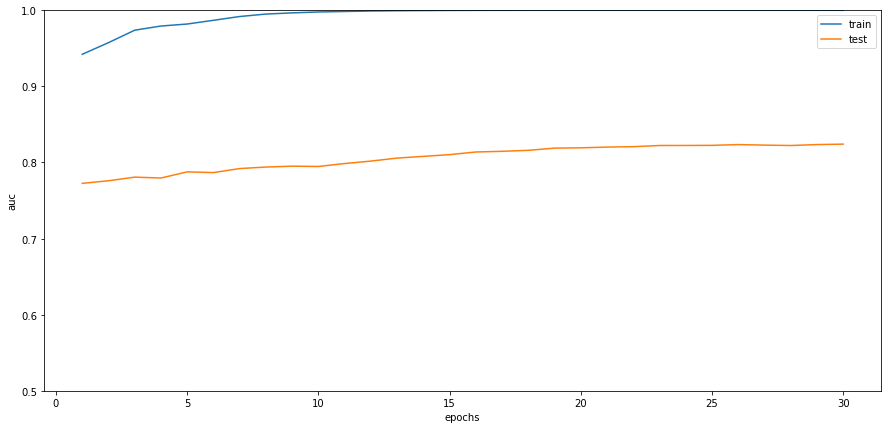

In [181]:
#zobrazujmy nasz proces trenowania na podstawie AUC

train_auc = model_xgb5.iloc[::,0]
test_auc = model_xgb5.iloc[::,2]
y_axis = range(1,model_xgb5.shape[0]+1)

plt.figure(figsize=(15, 7))
plt.plot(y_axis,train_auc, label = "train")
plt.plot(y_axis,test_auc, label = "test")
plt.xlabel("epochs")
plt.ylabel("auc")
plt.ylim([0.5, 1])
plt.legend()
_=plt.show()

Rowniez metoda z cross walidacja nie przynosi wyzsze jakosci klasyfikacji.


In [60]:
# dobierzmy jeszcze do naszego najlepszego modelu najbardziej optymalny zestaw parametrów i spróbujmy z inna metoda walidacji i innym scoremem
params_xgb2 = {"max_depth"        :list(range(11, 15, 1)),
              "n_estimators"      :list(range(50,211,40)),
              "learning_rate"     :list(np.linspace(0.1,0.40, 5))
}



In [62]:
#zdefiniujmy obiekt sprawdzajacy nasze parametry
model_xgb5 = XGBClassifier(booster = "gbtree",n_jobs = 3,eval_metric='mlogloss',objective='binary:logistic')
skf = StratifiedKFold(n_splits=5, shuffle = True)
grid_search2 =  GridSearchCV(model_xgb5,param_grid = params_xgb2,cv =skf,verbose = 1,scoring = make_scorer(balanced_accuracy_score)).fit(X_train_all_scaled,Y_train_all)
Beep(400,1000)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Dawid\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  2.4min finished


In [84]:
# sprawdzmy nasz najlepszy zestaw parametrow
print(grid_search2.best_params_)

model_xgb5 = grid_search2.best_estimator_
model_xgb5.fit(X_train_all_scaled,Y_train_all)

pred_xgb5 = model_xgb5.predict(X_test_scaled)

{'learning_rate': 0.4, 'max_depth': 14, 'n_estimators': 210}


In [85]:
#ocena jakosci modelu z wybranymi najlepszymi parametrami
xgb5_cnf_matrix = confusion_matrix(Y_test, pred_xgb5)
xgb5_cnf_raport = classification_report(Y_test, pred_xgb5)
print(xgb5_cnf_raport)
print(xgb5_cnf_matrix)

              precision    recall  f1-score   support

           1       0.95      0.97      0.96       272
           2       0.79      0.69      0.73        48

    accuracy                           0.93       320
   macro avg       0.87      0.83      0.84       320
weighted avg       0.92      0.93      0.92       320

[[263   9]
 [ 15  33]]


Kolejna poprawa naszego modelu, uzyskujemy wynik 73% dla klasy 2 i 96% dla klasy 1

**3. Sprobujmy zmodyfikować progi klasyfikacji dla naszego najlepszego modelu**

In [89]:
#wyciagnijmy nie klasyfikacje a prawdopodobienstwa
Y_pred_xgb5_proba = model_xgb5.predict_proba(X_test_scaled)[::,1]

In [90]:
lista = []
zbior_i = []
zbior_f1 = []
for i in np.linspace(0.1,0.9,30):
    lista = [2 if Y_pred_xgb5_proba[x] >= i else 1 for x in range(Y_pred_xgb5_proba.size)]
    print("trashold ="+ str(round(i,2)) + ", F1 score= " + str(round(f1_score(Y_test, lista,average = 'macro'),2)))
    zbior_i.append(i)
    zbior_f1.append(round(f1_score(Y_test, lista,average = 'macro'),2))

trashold =0.1, F1 score= 0.83
trashold =0.13, F1 score= 0.83
trashold =0.16, F1 score= 0.83
trashold =0.18, F1 score= 0.83
trashold =0.21, F1 score= 0.83
trashold =0.24, F1 score= 0.83
trashold =0.27, F1 score= 0.85
trashold =0.29, F1 score= 0.85
trashold =0.32, F1 score= 0.86
trashold =0.35, F1 score= 0.86
trashold =0.38, F1 score= 0.86
trashold =0.4, F1 score= 0.84
trashold =0.43, F1 score= 0.84
trashold =0.46, F1 score= 0.84
trashold =0.49, F1 score= 0.84
trashold =0.51, F1 score= 0.84
trashold =0.54, F1 score= 0.84
trashold =0.57, F1 score= 0.84
trashold =0.6, F1 score= 0.84
trashold =0.62, F1 score= 0.84
trashold =0.65, F1 score= 0.84
trashold =0.68, F1 score= 0.84
trashold =0.71, F1 score= 0.83
trashold =0.73, F1 score= 0.82
trashold =0.76, F1 score= 0.82
trashold =0.79, F1 score= 0.81
trashold =0.82, F1 score= 0.81
trashold =0.84, F1 score= 0.8
trashold =0.87, F1 score= 0.79
trashold =0.9, F1 score= 0.78


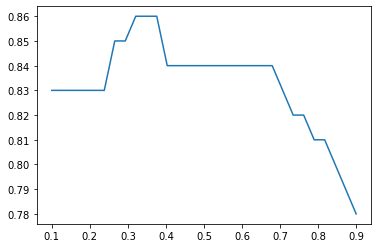

In [91]:
plt.plot(zbior_i,zbior_f1)
pass

In [92]:
#pozycja najlepszego wyniku
pozycja = np.min(np.where(zbior_f1 == np.max(zbior_f1)))
#najlepszy wynik wypada przy progu
prog = zbior_i[pozycja]
prog 

0.3206896551724138

In [94]:
# Sprawdzmy dokladnosc modelu przy tym progu
Y_pred_xgb5_prog = [2 if Y_pred_xgb5_proba[x] >= prog else 1 for x in range(Y_pred_xgb5_proba.size)]

In [96]:
#ocena jakosci modelu na nowym progu
xgb5_prog_cnf_matrix = confusion_matrix(Y_test, Y_pred_xgb5_prog)
xgb5_prog_cnf_raport = classification_report(Y_test, Y_pred_xgb5_prog)
print(xgb5_prog_cnf_raport)
print(xgb5_prog_cnf_matrix)

              precision    recall  f1-score   support

           1       0.96      0.96      0.96       272
           2       0.77      0.75      0.76        48

    accuracy                           0.93       320
   macro avg       0.86      0.85      0.86       320
weighted avg       0.93      0.93      0.93       320

[[261  11]
 [ 12  36]]


In [ ]:
Nasz ostateczny model uzyskał dokładność 93%, z 96% precyzja wskazuje dobrze klase 1 a z 76% klasę 2. 